In [1]:
# From: https://www.kaggle.com/c/dog-breed-identification/data
# Author: Morpheus Hsieh

from __future__ import print_function, division

# import os, sys
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from PIL import Image
from os import listdir
from os.path import join

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms, utils

In [5]:
RawPath = r'D:\GitWork\dog_breed\data\raw'
print("Raw path: '{}'".format(RawPath))

ProcPath = r'D:\GitWork\dog_breed\data\processed'
print("Processed path: '{}'".format(ProcPath))

BatchSize = 6

Phase = ['train', 'valid']

Raw path: 'D:\GitWork\dog_breed\data\raw'
Processed path: 'D:\GitWork\dog_breed\data\processed'


In [7]:
# Normalize
normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std  = [0.229, 0.224, 0.225]
)

# Transform
transform = transforms.Compose([
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    normalize
])

class myDataset(Dataset):
    
    def __init__(self, path, phase='train', transform=None):
        npy_types = ['images', 'labels']
        npy_files = ['{}_{}.npy'.format(phase, x) for x in npy_types]
        
        self.images = np.load(join(path, npy_files[0]))
        self.labels = np.load(join(path, npy_files[1]))

        self.transform = transform
        self.len = len(self.images)

    def __getitem__(self, index):
        img_path = self.images[index]
        img_pil = Image.open(img_path)

        if self.transform is not None:
            img = self.transform(img_pil)

        lbl = int(self.labels[index])
        
        return [img, lbl]

    def __len__(self):
        return self.len

    
trainSet = myDataset(ProcPath, transform=transform)
validSet = myDataset(ProcPath, phase='valid', transform=transform)
print('\nTrainSet size: ', len(trainSet))
print('ValidSet size: ', len(validSet))

trainLoader = DataLoader(trainSet, batch_size=BatchSize, shuffle=True)
validLoader = DataLoader(validSet, batch_size=BatchSize, shuffle=False)
print('\nTrainLoader size: ', len(trainLoader))
print('ValidLoader size: ', len(validLoader))

trainSize = len(trainSet)
validSize = len(validSet)

imgs, lbls = next(iter(trainLoader))
print('\nImage type: ', type(imgs))
print('      size: ', imgs.size())

print('\nLabel type: ', type(lbls))
print('      size: ', lbls.size())

img = imgs[0]
print('\nImage: ', img.shape)
print(); print(img)

print('\nLabel: ', lbls)


TrainSet size:  8177
ValidSet size:  2045

TrainLoader size:  1363
ValidLoader size:  341

Image type:  <class 'torch.Tensor'>
      size:  torch.Size([6, 3, 224, 224])

Label type:  <class 'torch.Tensor'>
      size:  torch.Size([6])

Image:  torch.Size([3, 224, 224])

tensor([[[-1.1247, -1.2445, -1.5870,  ..., -1.5357, -1.5014, -1.7240],
         [-1.0733, -1.2788, -1.4500,  ..., -1.8097, -1.7754, -1.7240],
         [-1.1075, -1.3644, -1.4158,  ..., -1.8439, -1.7583, -1.4843],
         ...,
         [-0.1657, -0.4397, -0.3712,  ..., -0.7822, -0.9534, -1.2445],
         [-0.0458, -0.3541, -0.1143,  ..., -1.3473, -1.3815, -1.2959],
         [-0.1314, -0.4568, -0.1828,  ..., -1.5870, -1.3815, -1.2445]],

        [[-0.6001, -0.7227, -1.0553,  ..., -1.1253, -1.0903, -1.3179],
         [-0.5301, -0.7402, -0.9153,  ..., -1.4055, -1.3704, -1.3179],
         [-0.5301, -0.7927, -0.8452,  ..., -1.4405, -1.3529, -1.0728],
         ...,
         [ 0.6078,  0.3277,  0.3978,  ..., -0.2150, -0.3901

In [9]:
import json

# Load breed dictionary from csv file
def getBreedDict(path, fname):
    csv_abspath = join(ProcPath, breed_dict_fname)
    df = pd.read_csv(csv_abspath)
    dic = {}
    for i, (b, bid) in df.iterrows():
        dic[bid] = b
    return dic    
    
breed_dict_fname = 'breed_dict.csv'
breed_dict_bw = getBreedDict(ProcPath, breed_dict_fname)
print(json.dumps(breed_dict_bw, indent=4))
# print(breed_dict_bw)

{
    "1": "affenpinscher",
    "2": "afghan_hound",
    "3": "african_hunting_dog",
    "4": "airedale",
    "5": "american_staffordshire_terrier",
    "6": "appenzeller",
    "7": "australian_terrier",
    "8": "basenji",
    "9": "basset",
    "10": "beagle",
    "11": "bedlington_terrier",
    "12": "bernese_mountain_dog",
    "13": "black-and-tan_coonhound",
    "14": "blenheim_spaniel",
    "15": "bloodhound",
    "16": "bluetick",
    "17": "border_collie",
    "18": "border_terrier",
    "19": "borzoi",
    "20": "boston_bull",
    "21": "bouvier_des_flandres",
    "22": "boxer",
    "23": "brabancon_griffon",
    "24": "briard",
    "25": "brittany_spaniel",
    "26": "bull_mastiff",
    "27": "cairn",
    "28": "cardigan",
    "29": "chesapeake_bay_retriever",
    "30": "chihuahua",
    "31": "chow",
    "32": "clumber",
    "33": "cocker_spaniel",
    "34": "collie",
    "35": "curly-coated_retriever",
    "36": "dandie_dinmont",
    "37": "dhole",
    "38": "dingo",
    "39

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image size: torch.Size([6, 3, 224, 224])
label size: torch.Size([6])


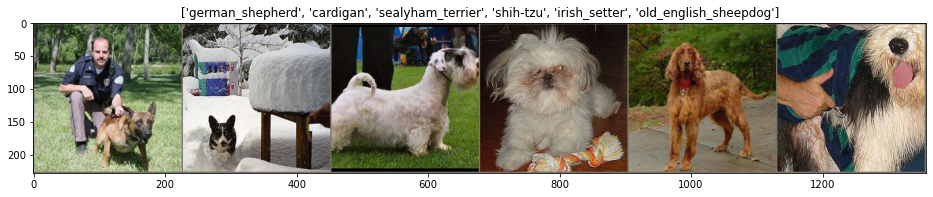

In [10]:
# Imshow for Tensor
def imshow(inp, title=None):
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    plt.figure(figsize=(16, 4))
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    return

sampleLoader = DataLoader(trainSet, batch_size=6, shuffle=True)    

# Get a batch of training data
imgs, lbls = next(iter(sampleLoader))
print('image size: {}'.format(imgs.size()))
print('label size: {}'.format(lbls.size()))

# Make a grid from batch
out = torchvision.utils.make_grid(imgs)
imshow(out, title=[breed_dict_bw.get(x.item()) for x in lbls])

In [11]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")
print(device)

cuda:0


In [12]:
# model
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(trainLoader))
if use_gpu:
    resnet = resnet.cuda()
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())   
else:
    inputs, labels = Variable(inputs), Variable(labels)

outputs = resnet(inputs)
outputs.size()

torch.Size([6, 1000])

In [13]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                
            scheduler.step()
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [14]:
resnet = models.resnet50(pretrained=True)

# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# new final layer with 16 classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 16)
if use_gpu:
    resnet = resnet.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dataLoaders = { 'train':trainLoader, 'valid':validLoader }

In [15]:
start_time = time.time()
model = train_model(dataLoaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=2)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

C:\opt\miniconda3\envs\py37\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)` (createCublasHandle at ..\aten\src\ATen\cuda\CublasHandlePool.cpp:8)
(no backtrace available)

In [ ]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return
            
visualize_model(dloaders, resnet)            